In [2]:
%load_ext watermark 
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import pytensor as pt
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
%watermark --iversions

pandas    : 1.5.3
matplotlib: 3.7.0
arviz     : 0.14.0
pymc      : 5.1.2
numpy     : 1.24.2
pytensor  : 2.10.1
altair    : 4.2.2



# Using GPs to capture relationships between species

This notebook is based off Statistical Rethinking 14.5.1 - phylogenetic distances.

In [5]:
primates = pd.read_csv("../../../datasets/Primates301.csv")
primates.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


In [6]:
complete_primates = primates[['name', 'brain', 'body', 'group_size']].dropna()
names = complete_primates.name.values
len(complete_primates)

151

In [7]:
complete_phylogeny = pd.read_csv("../../../datasets/Primates_phylogeny.csv")
complete_phylogeny.head()

,Allenopithecus_nigroviridis,Alouatta_belzebul,Alouatta_caraya,Alouatta_guariba,Alouatta_palliata,Alouatta_pigra,Alouatta_seniculus,Aotus_azarai,Aotus_trivirgatus,Arctocebus_calabarensis,...,Tarsius_syrichta,Theropithecus_gelada,Trachypithecus_cristatus,Trachypithecus_geei,Trachypithecus_johnii,Trachypithecus_obscurus,Trachypithecus_phayrei,Trachypithecus_pileatus,Trachypithecus_vetulus,Varecia_variegata_variegata
0,0.000000,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,1.0,...,0.942975,0.203761,0.293281,0.293281,0.293281,0.293281,0.293281,0.293281,0.293281,1.0
1,0.641231,0.000000,0.053261,0.062590,0.046867,0.046867,0.053261,0.292061,0.292061,1.0,...,0.942975,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,1.0
2,0.641231,0.053261,0.000000,0.062590,0.053261,0.053261,0.039539,0.292061,0.292061,1.0,...,0.942975,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,1.0
3,0.641231,0.062590,0.062590,0.000000,0.062590,0.062590,0.062590,0.292061,0.292061,1.0,...,0.942975,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,1.0
4,0.641231,0.046867,0.053261,0.062590,0.000000,0.021673,0.053261,0.292061,0.292061,1.0,...,0.942975,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,0.641231,1.0


# Basic linear regression

In [53]:
coords = {
        'species': names,
        'params': ['Group size', 'Body Mass']
    }

def standardize(a):
    return (a - a.mean()) / a.std()

def register_data(RVs, data):
    #data
    data['G'] = pm.ConstantData("group size", standardize(np.log(complete_primates['group_size'].values)), dims="species")
    data['M'] = pm.ConstantData("body mass", standardize(np.log(complete_primates['body'].values)), dims="species")
    data['B'] = pm.ConstantData("brain size", standardize(np.log(complete_primates['brain'].values)), dims="species")

def lin_params(RVs, data): 
    #priors
    RVs['α'] = pm.Normal("α", 0, 1)
    RVs['β'] = pm.Normal("β", 0, 0.5, dims='params')
    RVs['σ'] = pm.Exponential('σ', 1)


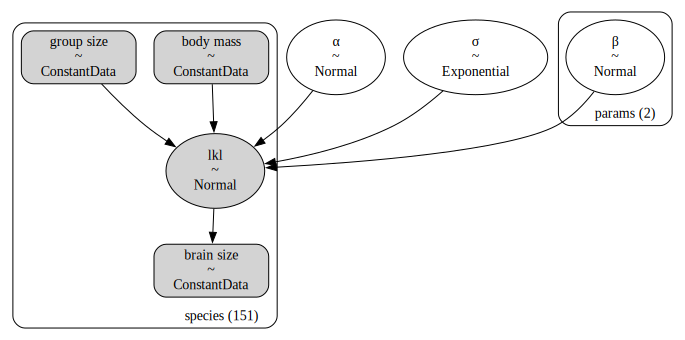

In [54]:
with pm.Model(coords= coords) as basic_linreg:
    data = {}
    RVs = {}
    register_data(RVs, data)
    lin_params(RVs, data)

    mu = RVs['α'] + data['G'] * RVs['β'][0] + data['M'] * RVs['β'][1]

    pm.Normal("lkl", mu, RVs['σ'], observed=data['B'], dims="species")


pm.model_to_graphviz(basic_linreg)

In [55]:
with basic_linreg:
    basic_trace = sampling_jax.sample_blackjax_nuts()    

Compiling...
Compilation time =  0:00:00.775077
Sampling...
Sampling time =  0:00:03.837803
Transforming variables...
Transformation time =  0:00:00.018089


In [56]:
az.summary(basic_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.000,0.017,-0.033,0.033,0.0,0.0,3577.0,2507.0,1.0
β[Group size],0.123,0.023,0.080,0.166,0.0,0.0,3392.0,2829.0,1.0
β[Body Mass],0.893,0.023,0.850,0.936,0.0,0.0,3393.0,2746.0,1.0
σ,0.217,0.013,0.194,0.241,0.0,0.0,3878.0,2778.0,1.0


## Multivariate form

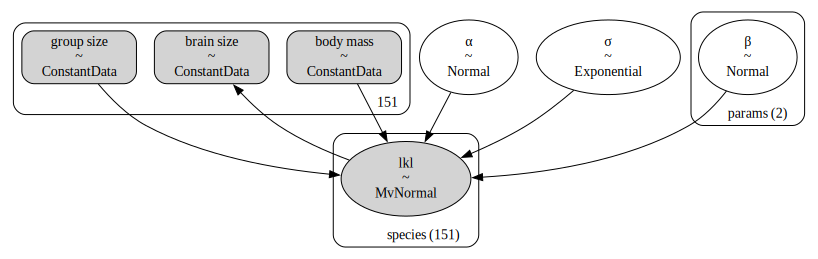

In [12]:
with pm.Model(coords= coords) as mv_linreg:
    data = {}
    RVs = {}
    register_data(RVs, data)
    lin_params(RVs, data)

    mu = RVs['α'] + data['G'] * RVs['β'][0] + data['M'] * RVs['β'][1]
    cov = np.identity(len(coords['species'])) * (RVs['σ']  ** 2)

    pm.MvNormal("lkl", mu, cov = cov, observed=data['B'], dims=["species"])

pm.model_to_graphviz(mv_linreg)

In [13]:
with mv_linreg:
    mv_trace = sampling_jax.sample_blackjax_nuts()    

Compiling...
Compilation time =  0:00:01.373323
Sampling...
Sampling time =  0:00:04.002061
Transforming variables...
Transformation time =  0:00:46.766623


In [14]:
az.summary(mv_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.000,0.018,-0.035,0.031,0.0,0.0,4080.0,2812.0,1.0
β[Group size],0.123,0.023,0.081,0.165,0.0,0.0,3221.0,2580.0,1.0
β[Body Mass],0.893,0.023,0.848,0.932,0.0,0.0,3521.0,2860.0,1.0
σ,0.217,0.013,0.193,0.240,0.0,0.0,3700.0,2560.0,1.0


## Intercept-only gaussian process (lecture version)

In [15]:
def add_distances(RVs, data, add_noise = True):
    raw_dist = complete_phylogeny.values.copy()
    if add_noise:
        raw_dist[0:len(raw_dist), 0:len(raw_dist)] += 0.01
    data['distances'] = pm.ConstantData("distances", raw_dist, coords=['species', 'species'])

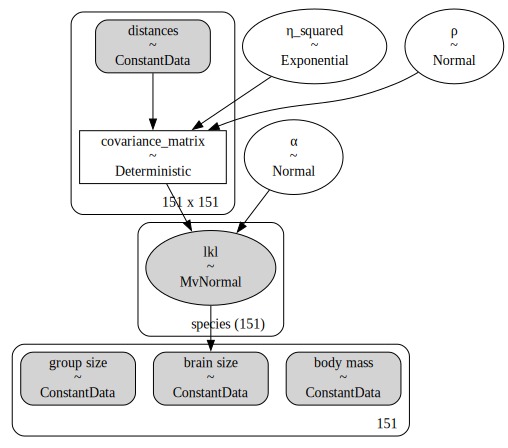

In [16]:
with pm.Model(coords= coords) as gp_intercept_lecture:
    data = {}
    RVs = {}
    register_data(RVs, data)
    add_distances(RVs, data)
    α = pm.Normal("α", 0, 1)

    #using different priors as the original ones were not affected by data
    η_squared = pm.Exponential("η_squared", 1)
    ρ = pm.Normal("ρ", 3, sigma=0.25)

    mu = α
    cov = pm.Deterministic("covariance_matrix", η_squared * pm.math.exp(- ρ * data['distances']))

    pm.MvNormal("lkl", mu, cov = cov, observed=data['B'], dims=["species"])

pm.model_to_graphviz(gp_intercept_lecture)

In [17]:
#a quick way to get prior samples
with gp_intercept_lecture:
    prior_cov_matrix = pm.draw([cov], draws=1000)

mean_cov_matrix = np.array(prior_cov_matrix[0]).mean(axis=0)

In [18]:
# another way that gets predicted values but takes longer
with gp_intercept_lecture:
    gp_intercept_lecture_priors = pm.sample_prior_predictive()

Sampling: [lkl, α, η_squared, ρ]


In [19]:
with gp_intercept_lecture:
    gp_intercept_lecture_trace = sampling_jax.sample_blackjax_nuts()    

Compiling...
Compilation time =  0:00:01.279423
Sampling...
Sampling time =  0:00:04.289996
Transforming variables...
Transformation time =  0:01:03.671036


In [18]:
az.summary(gp_intercept_lecture_trace, var_names="~covariance_matrix")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.597,0.258,-1.081,-0.111,0.005,0.003,2786.0,2483.0,1.0
ρ,2.376,0.240,1.930,2.818,0.005,0.003,2674.0,2375.0,1.0
η_squared,0.386,0.049,0.294,0.476,0.001,0.001,2841.0,2874.0,1.0


In [20]:
mean_cov_mat = pd.concat(
    [pd.DataFrame({
    "distance": complete_phylogeny.values[0,].flatten(), 
    "cov": gp_intercept_lecture_trace['posterior']['covariance_matrix'].mean(dim=['draw', 'chain']).to_numpy()[0],
    "source": 'posterior'
}),
pd.DataFrame({
    "distance": complete_phylogeny.values[0,].flatten(), 
    "cov": gp_intercept_lecture_priors['prior']['covariance_matrix'].mean(dim=['draw', 'chain']).to_numpy()[0],    
    "source": 'prior'
}),
pd.DataFrame({
    "distance": complete_phylogeny.values[0,].flatten(),     
    'cov': mean_cov_matrix[0,:],
    "source": 'prior-samples'
})]
)

In [21]:
alt.Chart(mean_cov_mat).mark_line().encode(x='distance', y='cov', color='source')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


## An implementation using pyMC GP features (the "hack" way)

Because we're working with a custom distance matrix, we'll subclass the pyMC kernel to allow working with it directly.

In [22]:
class ExponentialHack(pm.gp.cov.Stationary):
    def full(self, X, Xs=None):        
        return pt.tensor.exp(-0.5 * (X) / pm.math.sqrt(self.ls))

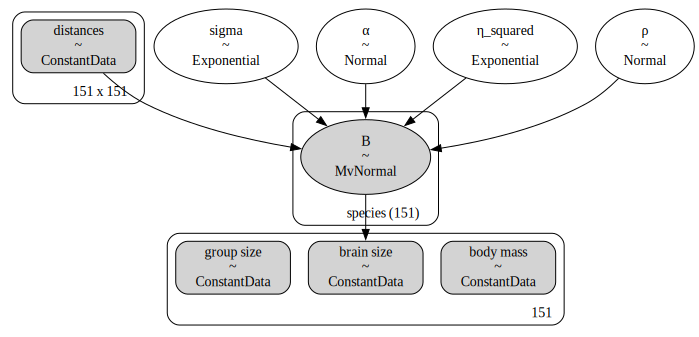

In [32]:
with pm.Model(coords= coords) as gp_intercept:
    data = {}
    RVs = {}
    register_data(RVs, data)
    add_distances(RVs, data, add_noise=False) #will add white noise via GP implementation instead
    α = pm.Normal("α", 0, 1)

    #using different priors as the original ones were not affected by data
    η_squared = pm.Exponential("η_squared", 1)
    ρ = pm.Normal("ρ", 3, sigma=0.25)
    ls = 1 / (2 * ρ)

    cov_func = η_squared * ExponentialHack(input_dim=151, ls=ls) 

    mu = pm.gp.mean.Constant(α)
    gp = pm.gp.Marginal(mean_func = mu, cov_func=cov_func)

    sigma = pm.Exponential("sigma", 1.0)
    gp.marginal_likelihood("B", X=data['distances'], y=data['B'], sigma=sigma, dims="species")

pm.model_to_graphviz(gp_intercept)

In [33]:
with gp_intercept:
    gp_intercept_trace = sampling_jax.sample_blackjax_nuts()    

Compiling...
Compilation time =  0:00:02.179988
Sampling...
Sampling time =  0:00:05.000900
Transforming variables...
Transformation time =  0:01:14.730434


In [37]:
az.summary(gp_intercept_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.539,0.427,-1.382,0.220,0.008,0.006,2991.0,2337.0,1.0
ρ,2.888,0.256,2.398,3.367,0.004,0.003,3333.0,2441.0,1.0
η_squared,0.578,0.071,0.451,0.716,0.001,0.001,3157.0,2612.0,1.0
sigma,0.021,0.015,0.000,0.047,0.000,0.000,2153.0,1390.0,1.0


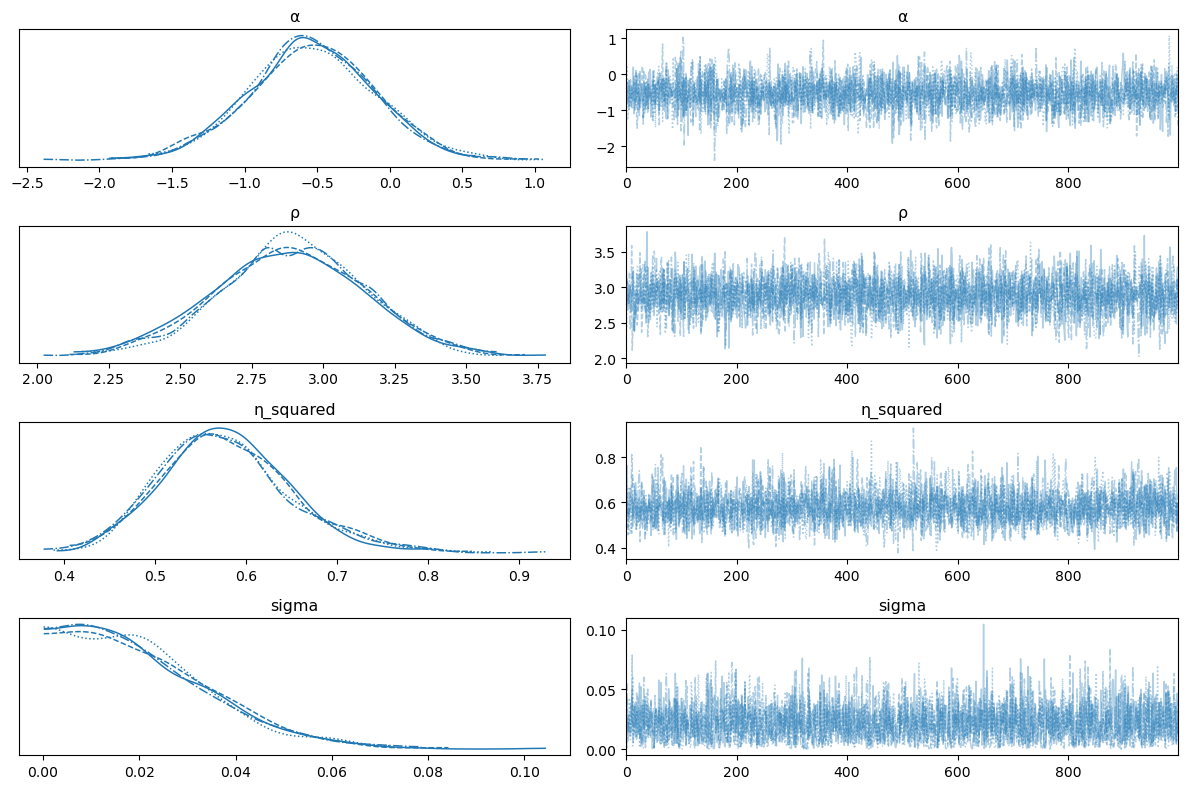

In [38]:
az.plot_trace(gp_intercept_trace)
plt.tight_layout()
plt.show()

## Final model

In [57]:
class LinearMean(pm.gp.mean.Linear):
    def __init__(self, coeffs, intercept=0, X=None):
        super().__init__(coeffs, intercept)
        self.X = X        

    def __call__(self, X):
        #return self.b + self.A * self.X
        return pt.tensor.squeeze(pt.tensor.dot(self.X, self.A) + self.b)

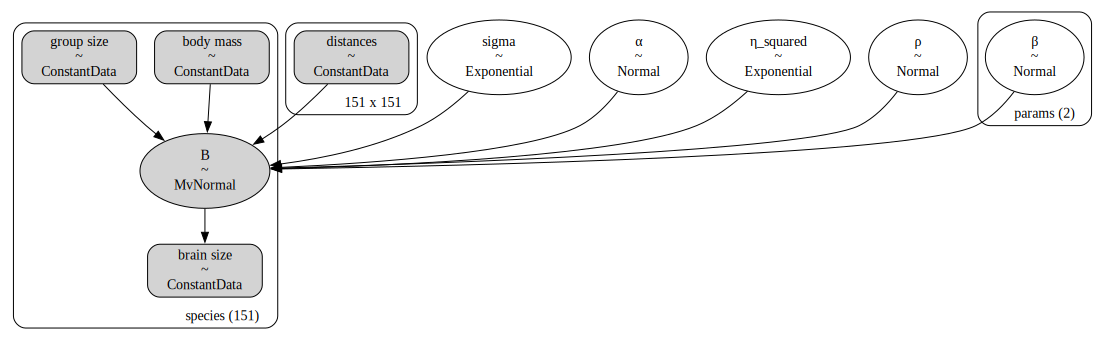

In [58]:
with pm.Model(coords= coords) as final_gp:
    data = {}
    RVs = {}
    register_data(RVs, data)
    add_distances(RVs, data, add_noise=False) #pyMC GP implementation adds white noise already
    α = pm.Normal("α", 0, 1)
    β = pm.Normal("β", 0, 0.5, dims='params')

    #using different priors as the original ones were not affected by data
    η_squared = pm.Exponential("η_squared", 1)
    ρ = pm.Normal("ρ", 3, sigma=0.25)
    ls = 1 / (2 * ρ)

    cov_func = η_squared * ExponentialHack(input_dim=151, ls=ls) 

    mu = LinearMean(intercept=α, coeffs=β, X=pt.tensor.stack([data['G'], data['M']], axis=1))
    gp = pm.gp.Marginal(mean_func = mu, cov_func=cov_func)

    sigma = pm.Exponential("sigma", 1.0)
    gp.marginal_likelihood("B", X=data['distances'], y=data['B'], sigma=sigma, dims="species")

pm.model_to_graphviz(final_gp)

In [59]:
with final_gp:
    final_trace = sampling_jax.sample_blackjax_nuts()    

Compiling...
Compilation time =  0:00:02.356443
Sampling...
Sampling time =  0:00:05.787279
Transforming variables...
Transformation time =  0:01:44.915549


In [60]:
az.summary(final_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.109,0.175,-0.450,0.194,0.002,0.002,5185.0,3015.0,1.0
β[Group size],0.027,0.020,-0.014,0.063,0.000,0.000,5026.0,3291.0,1.0
β[Body Mass],0.780,0.031,0.719,0.834,0.000,0.000,4578.0,3284.0,1.0
ρ,2.953,0.257,2.467,3.435,0.004,0.003,4851.0,2653.0,1.0
η_squared,0.077,0.013,0.052,0.102,0.000,0.000,3954.0,2538.0,1.0
sigma,0.055,0.009,0.038,0.071,0.000,0.000,4105.0,2978.0,1.0


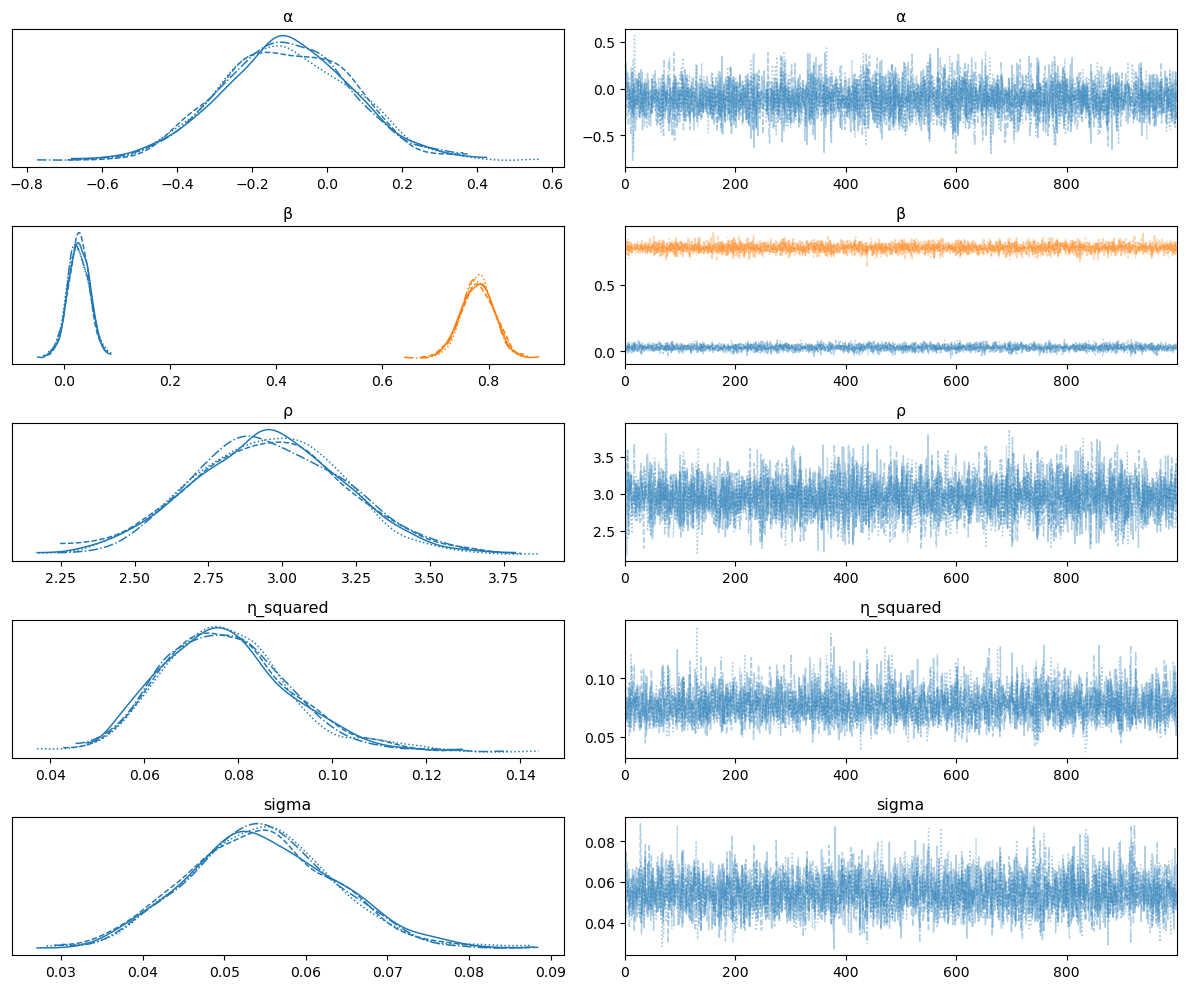

In [61]:
az.plot_trace(final_trace)
plt.tight_layout()
plt.show()

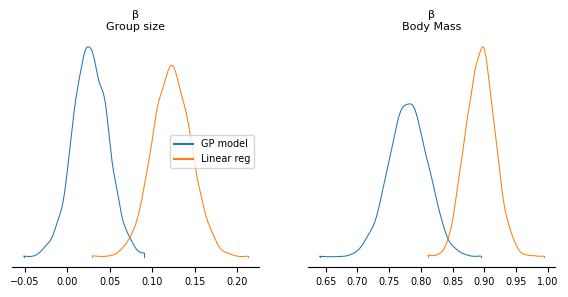

In [102]:
az.plot_density(
    [final_trace, basic_trace], 
    var_names=['β'], 
    data_labels=['GP model', 'Linear reg'],
    figsize=(7,3), textsize=7, point_estimate=None, hdi_prob=1
)
plt.show()